In [1]:
# 1. download HTML files
import os
import requests

if not os.path.exists("html"):
    os.mkdir("html")
    
    for i in range(10):
        url = "https://www.cityofmadison.com/fire/daily-reports?page=" + str(i)
        print(url)
        response = requests.get(url)
        response.raise_for_status()
        with open(os.path.join("html", str(i)+".html"), "w") as f:
            f.write(response.text)

In [2]:
# 2. HTML to DataFrame
from bs4 import BeautifulSoup
import pandas as pd

def html_to_df(path):
    with open(path) as f:
        html = f.read()

    page = BeautifulSoup(html)

    # find table
    for div in page.find_all("div"):
        if 'pseudo-table' in div.attrs.get("class", []):
            table = div
            break

    # find rows in table
    rows = []
    for div in table.find_all("div"):
        if 'row' in div.attrs.get("class", []):
            row = []
            for cell in div.find_all("div"):
                cell = cell.get_text().split(":")[-1].strip()
                row.append(cell)
            rows.append(row[:4])

    return pd.DataFrame(rows[1:], columns=rows[0])

dfs = []
for i in range(10):
    df = html_to_df(os.path.join("html", str(i)+".html"))
    dfs.append(df)
df = pd.concat(dfs).reset_index()
df.head()

,index,Incident,Date,Incident Type,Address
0,0,One Injured Following 8-foot Fall Into Open Grate,11/01/2021,Special Rescue,"3800 Block Regent StreetMadison, WI"
1,1,Fire Caused By Discarded Ashes Damages East Si...,11/01/2021,Trash/Rubbish,"3800 Block Clover LaneMadison, WI"
2,2,One Person Rescued From Lake Monona,10/31/2021,Lake Rescue,"10 Block John Nolen DriveMadison, WI"
3,3,Dog perishes in early morning fire,10/29/2021,Structure,"2900 Block Monroe StMadison, WI"
4,4,Natural Gas Leak Identified In S. Stoughton Ro...,10/20/2021,Gas Leak,"2600 Block S. Stoughton RoadMadison, WI"


In [4]:
# 3. geocoding: address => lat/lon
import geopandas as gpd

gpd.tools.geocode("1210 W. Dayton Street").values

array([[<shapely.geometry.point.Point object at 0x7f5404573160>,
        'Computer Sciences and Statistics, 1210, West Dayton Street, 53706, West Dayton Street, Madison, WI, United States']],
      dtype=object)

In [49]:
# open street maps (provider is nominatim)
gpd.tools.geocode("1210 Dayton Street; Madison, WI",
                  provider="nominatim", user_agent="cs320-tyler").values

array([[<shapely.geometry.point.Point object at 0x7fa01e57df10>,
        'Computer Sciences and Statistics, 1210, West Dayton Street, South Campus, Bowens Addition, Madison, Dane County, Wisconsin, 53706, United States']],
      dtype=object)

In [55]:
df["Address"] = df["Address"].str.replace("Madison", "; Madison").str.replace(" Block ", " ")
df

,index,Incident,Date,Incident Type,Address
0,0,One Injured Following 8-foot Fall Into Open Grate,11/01/2021,Special Rescue,"3800 Regent Street; Madison, WI"
1,1,Fire Caused By Discarded Ashes Damages East Si...,11/01/2021,Trash/Rubbish,"3800 Clover Lane; Madison, WI"
2,2,One Person Rescued From Lake Monona,10/31/2021,Lake Rescue,"10 John Nolen Drive; Madison, WI"
3,3,Dog perishes in early morning fire,10/29/2021,Structure,"2900 Monroe St; Madison, WI"
4,4,Natural Gas Leak Identified In S. Stoughton Ro...,10/20/2021,Gas Leak,"2600 S. Stoughton Road; Madison, WI"
...,...,...,...,...,...
95,5,One Injured In Flash Fire At Oil Change Facility,02/05/2021,Explosion,"3700 Milwaukee Street; Madison, WI"
96,6,Cooking Fire Injures One,01/31/2021,Cooking,"7100 Tree Lane; Madison, WI"
97,7,Carbon Monoxide Buildup the Result of Snow Blo...,01/26/2021,Carbon Monoxide,"2100 Pike Drive; Madison, WI"
98,8,Worker Seriously Injured Following Fall At Con...,01/25/2021,EMS,N. Ingersoll Street & E. Mifflin Street; Madis...


In [56]:
gpd.tools.geocode(df["Address"].iloc[:5],
                  provider="nominatim", user_agent="cs320-tyler")

,geometry,address
0,POINT (-89.43876 43.06809),"3800, Regent Street, VanChaMasShe, Madison, Da..."
1,POINT (-89.32256 43.08676),"3800, Clover Lane, Madison, Dane County, Wisco..."
2,POINT (-89.38597 43.06628),"John Nolen Drive, Bassett, Madison, Dane Count..."
3,POINT (-89.43067 43.05612),"2900, Monroe Street, Dudgeon-Monroe, Madison, ..."
4,POINT (-89.30914 43.05826),"2600, South Stoughton Road, Glendale Townhouse..."


In [62]:
df["geometry"] = None

for idx in df.index:
    addr = df.at[idx, "Address"]
    coord_df = gpd.tools.geocode(addr, provider="nominatim", user_agent="cs320-tyler")
    coord = coord_df.at[0, "geometry"]
    df.at[idx, "geometry"] = coord
    print(addr, coord)
    
df.head()

3800 Regent Street; Madison, WI POINT (-89.438756 43.068087)
3800 Clover Lane; Madison, WI POINT (-89.322563 43.086765)
10 John Nolen Drive; Madison, WI POINT (-89.38597179999999 43.06628)
2900 Monroe St; Madison, WI POINT (-89.430666 43.056119)
2600 S. Stoughton Road; Madison, WI POINT (-89.30913605303704 43.05826223453485)
5500 Denton Place; Madison, WI POINT (-89.473569 43.030882)
2500 Independence Lane; Madison, WI POINT (-89.30818748575575 43.13135104536706)
1300 Mendota Street; Madison, WI POINT (-89.31761253115809 43.11602884480136)
200 N. First Street; Madison, WI GEOMETRYCOLLECTION EMPTY
2300 S. Park Street; Madison, WI POINT (-89.39549008993453 43.04116985)
6700 Jacobs Way; Madison, WI POINT (-89.4969163424731 43.03811871431542)
8200 Highview Drive ; Madison, WI POINT (-89.523048 43.053662)
1300 N. Sherman Avenue; Madison, WI POINT (-89.36389800000001 43.114368)
Milwaukee Street & West Corporate Drive; Madison, WI GEOMETRYCOLLECTION EMPTY
2200 Independence Lane; Madison, WI P

,index,Incident,Date,Incident Type,Address,geometry
0,0,One Injured Following 8-foot Fall Into Open Grate,11/01/2021,Special Rescue,"3800 Regent Street; Madison, WI",POINT (-89.438756 43.068087)
1,1,Fire Caused By Discarded Ashes Damages East Si...,11/01/2021,Trash/Rubbish,"3800 Clover Lane; Madison, WI",POINT (-89.322563 43.086765)
2,2,One Person Rescued From Lake Monona,10/31/2021,Lake Rescue,"10 John Nolen Drive; Madison, WI",POINT (-89.38597179999999 43.06628)
3,3,Dog perishes in early morning fire,10/29/2021,Structure,"2900 Monroe St; Madison, WI",POINT (-89.430666 43.056119)
4,4,Natural Gas Leak Identified In S. Stoughton Ro...,10/20/2021,Gas Leak,"2600 S. Stoughton Road; Madison, WI",POINT (-89.30913605303704 43.05826223453485)


In [65]:
type(df)

pandas.core.frame.DataFrame

<AxesSubplot:>

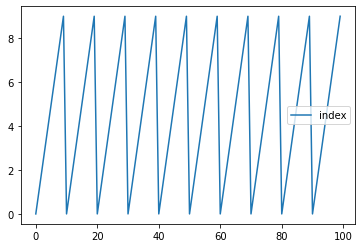

In [64]:
df.plot()

In [5]:
# 4. create GeoDataFrame

# two major formats for geodata:
# shapefiles (.shp)
# geojson

gdf = gpd.GeoDataFrame(df)
gdf.to_file("fire.geojson")

AttributeError: No geometry data set yet (expected in column 'geometry'.)

<AxesSubplot:>

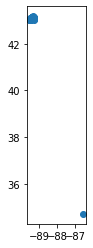

In [6]:
# 5. draw frame
fire = gpd.read_file("fire.geojson")
fire.plot()

In [9]:
# gdf1.intersection(gdf2) -- that will do a row-by-row intersection
# gdf1.intersection(ONE_BIG_SHAPE)

(100, 4)

<AxesSubplot:>

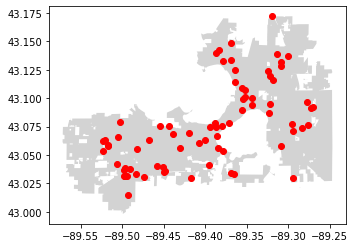

In [17]:
city = gpd.read_file("City_Limit.zip")
ax = city.plot(color="lightgray")
fire.intersection(city.unary_union).plot(ax=ax, color="red")

In [23]:
# pd.to_datetime(...)
# pd.Timedelta(...)

<function pandas.core.tools.datetimes.to_datetime(arg: 'DatetimeScalarOrArrayConvertible', errors: 'str' = 'raise', dayfirst: 'bool' = False, yearfirst: 'bool' = False, utc: 'bool | None' = None, format: 'str | None' = None, exact: 'bool' = True, unit: 'str | None' = None, infer_datetime_format: 'bool' = False, origin='unix', cache: 'bool' = True) -> 'DatetimeIndex | Series | DatetimeScalar | NaTType | None'>

In [33]:
dates = pd.to_datetime(fire["Date"])
frames = (dates - dates.min()) // pd.Timedelta(7, "days")
frames.head()

0    40
1    40
2    40
3    40
4    39
Name: Date, dtype: int64

In [35]:
fire["frame"] = frames
fire.head()

,index,Incident,Date,Incident Type,Address,geometry,frame
0,0,One Injured Following 8-foot Fall Into Open Grate,11/01/2021,Special Rescue,"3800 Regent Street; Madison, WI",POINT (-89.43876 43.06809),40
1,1,Fire Caused By Discarded Ashes Damages East Si...,11/01/2021,Trash/Rubbish,"3800 Clover Lane; Madison, WI",POINT (-89.32256 43.08676),40
2,2,One Person Rescued From Lake Monona,10/31/2021,Lake Rescue,"10 John Nolen Drive; Madison, WI",POINT (-89.38597 43.06628),40
3,3,Dog perishes in early morning fire,10/29/2021,Structure,"2900 Monroe St; Madison, WI",POINT (-89.43067 43.05612),40
4,4,Natural Gas Leak Identified In S. Stoughton Ro...,10/20/2021,Gas Leak,"2600 S. Stoughton Road; Madison, WI",POINT (-89.30914 43.05826),39


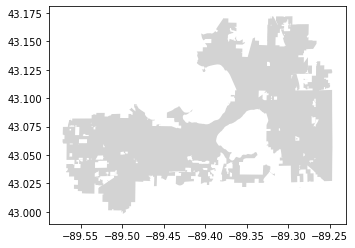

In [56]:
def draw_frame(frame_num):
    ax = city.plot(color="lightgray")
    subset = fire[fire["frame"] == frame_num]
    subset = subset[~subset["geometry"].isna()]
    subset["geometry"] = subset.intersection(city.unary_union)
    subset = subset[~subset["geometry"].is_empty]
    if len(subset):
        subset.plot(ax=ax, color="red")
    
draw_frame(19)

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


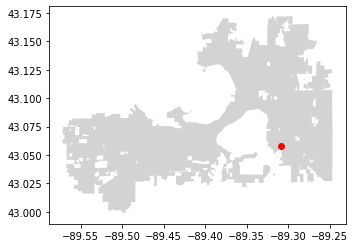

In [61]:
# 6. create animation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

def draw_frame(frame_num):
    print(frame_num)
    ax.cla() # clear anything previously drawn
    city.plot(color="lightgray", ax=ax)
    subset = fire[fire["frame"] == frame_num]
    subset = subset[~subset["geometry"].isna()]
    subset["geometry"] = subset.intersection(city.unary_union)
    subset = subset[~subset["geometry"].is_empty]
    if len(subset):
        subset.plot(ax=ax, color="red")

anim = FuncAnimation(fig, draw_frame, frames=fire["frame"].max(), interval=500)
html = anim.to_html5_video()

In [62]:
from IPython.core.display import HTML
HTML(html)